In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from datetime import datetime
from datetime import timedelta
import matplotlib.cm as cm
import scipy

# plotting stuff 

In [2]:
def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qo - Qm)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)
    
def calc_log_NSE(Qo, Qm):
    Qo[Qo == 0] = 1e-6
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((np.log(Qo) - np.log(Qm))**2)
    ErrDo = np.sum((np.log(Qo) - np.log(QoAv))**2)
    return 1 - (ErrUp / ErrDo)

In [3]:
units= {"Imax":"mm",
        "Ce": "-",
        "Sumax": "mm",
        "Beta": "-",
        "Pmax": "mm",
        "Tlag": "d",
        "Kf": "-",
        "Ks": "-",
        "FM":'mm/d/degC',
        "Si": "mm",
        "Su": "mm",
        "Sf": "mm",
        "Ss": "mm",
        "Sp": "mm",
        "Ei_dt": "mm/d",
        "Ea_dt": "mm/d",
        "Qs_dt": "mm/d",
        "Qf_dt": "mm/d",
        "Q_tot_dt": "mm/d",
        "Q": "mm/d"}

p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
names = p_names + S_names
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]

var_names =  {x: names[i] for i, x in enumerate(param_names + stor_names)}

In [4]:
def plot_hydrograph(ds_combined, ax, summary_stat):
    NSE_mean = calc_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat=summary_stat).values)
    NSE_mean_log = calc_log_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat=summary_stat).values)
    
    ds_combined["Q_obs"].plot(ax=ax,lw=0,marker="*",ms=2.0,zorder=0,label="Observations",color='k')
    
    ds_combined["Q"].sel(summary_stat=summary_stat).plot(ax=ax, color="C1",lw=0.5,label=f"NSE: {NSE_mean:.2f}\n   Log NSE: {NSE_mean_log:.2f}",zorder=-1)
    
    ax.fill_between(ds_combined.time, 
                             ds_combined["Q"].sel(summary_stat="min").values,
                             ds_combined["Q"].sel(summary_stat="max").values,color="C0", alpha=0.35,zorder=-10,label="bounds")
    n_particles = ds_combined.attrs['n_particles']
    ax.set_ylabel("Q [mm]")
    ax.set_title(f"Run ensemble of {n_particles} particles");
    return ax

In [5]:
def plot_variable(ds_combined, variable, axs):    
    axs[0] = plot_hydrograph(ds_combined, axs[0])
    n_particles = ds_combined.attrs['n_particles']
    
    for i, var in enumerate(variable):
        axs[i+1].fill_between(ds_combined.time, 
                         ds_combined[var].sel(summary_stat="min").values,
                         ds_combined[var].sel(summary_stat="max").values, color=f"C{i}",alpha=0.5)
        axs[i+1].set_title(var_names[var])
        axs[i+1].set_ylabel(f'{var} [{units[var]}]')
    return axs

In [6]:
path = Path.cwd() 
figure_path = path / "Figures"

# loading

### DA best ensemble member

In [7]:
best_ds_files = list((path.parent.parent.parent / "run_experiment_best" / 'Output').glob("*.nc"))

In [8]:
best_ds_lst = []
for file in best_ds_files:
    best_ds_lst.append(xr.open_dataset(file))

In [9]:
df_best = pd.DataFrame(columns=["NSE_mean_DA","log_NSE_mean_DA","NSE_best_DA","log_NSE_best_DA","path_DA"],)
for index, ds in enumerate(best_ds_lst):
    uid = ds.attrs['HRU_id']
    df_best.loc[uid, 'NSE_mean_DA'] = calc_NSE(ds["Q_obs"].values, ds["Q"].sel(summary_stat="mean").values)
    df_best.loc[uid, 'log_NSE_mean_DA'] = calc_log_NSE(ds["Q_obs"].values, ds["Q"].sel(summary_stat="mean").values)
    df_best.loc[uid, 'NSE_best_DA'] = calc_NSE(ds["Q_obs"].values, ds["Q"].sel(summary_stat="best").values)
    df_best.loc[uid, 'log_NSE_best_DA'] = calc_log_NSE(ds["Q_obs"].values, ds["Q"].sel(summary_stat="best").values)
    df_best.loc[uid,'path_DA'] = best_ds_files[index]
    df_best.loc[uid,'Q_spread'] = ((ds["Q"].sel(summary_stat='max') - ds["Q"].sel(summary_stat='min'))/ds["Q"].sel(summary_stat='mean')).mean().values 
    df_best.loc[uid, 'DA_sse'] = (np.sum((ds['Q_obs'].to_numpy() -  ds['Q'].to_numpy())**2))

### calibration

In [10]:
callibration_ds_files = list((path.parent.parent.parent / "run_callibration" / 'Output').glob("*.nc"))

In [11]:
cal_ds_lst = []
for file in callibration_ds_files:
    cal_ds_lst.append(xr.open_dataset(file))

## combine

In [12]:
df_cal = pd.DataFrame(columns=["NSE_cal","log_NSE_cal","path_cal"]+[f'cal_{param}' for param in param_names])
for index, ds in enumerate(cal_ds_lst):
    uid = ds.attrs['HRU_id']
    df_cal.loc[uid, 'NSE_cal'] = ds.attrs['NSE_max']
    df_cal.loc[uid, 'log_NSE_cal'] = ds.attrs['log_NSE_max']
    df_cal.loc[uid,'path_cal'] = callibration_ds_files[index]
    if ds.EnsembleMember.size == 2 :
        if len(set(ds.EnsembleMember.to_numpy())) == 1:
            ds = ds.sel(EnsembleMember=ds.attrs['i_NSE_max']).isel(EnsembleMember=0) 
        else:
            ds = ds.sel(EnsembleMember=ds.attrs['i_NSE_max'])
    else:
        ds = ds

    sse = np.sum((ds['Q_obs'].to_numpy() -  ds['Q'].to_numpy())**2)
    df_cal.loc[uid,'cal_sse'] = sse

    if len(ds["Imax"].coords) == 2:
        param_series = ds.isel(time=0)[param_names].to_pandas()
    else:
        param_series = ds[param_names].to_pandas()

    for param in param_names:
        df_cal.loc[uid, f'cal_{param}'] = param_series[param]

In [13]:
indexes = list(set(df_cal.index).intersection(df_best.index))

In [14]:
df_cal_common = df_cal.loc[indexes]
df_best_common = df_best.loc[indexes]

In [15]:
df = pd.concat([df_cal_common,df_best_common],axis=1)
len_df_all = len(df)
df = df[(df['NSE_cal'] > 0 ) & (df['NSE_best_DA'] > 0 ) ] # & (df['log_NSE_mean_DA'] > 0 )& (df['log_NSE_mean_DA'] > 0 )]
df['NSE_delta_mean'] = df['NSE_mean_DA'] - df['NSE_cal']
df['NSE_delta_best'] = df['NSE_best_DA'] - df['NSE_cal']
df['log_NSE_delta_mean'] = df['log_NSE_mean_DA'] - df['log_NSE_cal']
df['log_NSE_delta_best'] = df['log_NSE_best_DA'] - df['log_NSE_cal']

In [16]:
columns_no_path = list(df.columns.copy())
columns_no_path.remove('path_DA')
columns_no_path.remove('path_cal')

# plot function

In [17]:
def generate_plots(df, catchment, fig_tuple):
    fig, axs = fig_tuple
    ds_lst = []
    ax = axs[0]
    ds = xr.open_dataset(df.loc[catchment]['path_DA'])
    ds_lst.append(ds)
    ax = plot_hydrograph(ds, ax, 'best')
    ax.legend(title=ds.attrs['HRU_id'],bbox_to_anchor=(1,1))
    ax.set_ylabel('Q (mm/d)')
    
    ax = axs[1]
    ds = xr.open_dataset(df.loc[catchment]['path_cal'])
    ds_lst.append(ds)
    plot_only_calibration(ds, ax)
    
    
    fig.tight_layout()
    fig_tuple = fig, axs
    return fig_tuple, ds_lst

In [18]:
def plot_only_calibration(ds, ax):
    if ds.EnsembleMember.size == 2 :
        if len(set(ds.EnsembleMember.to_numpy())) == 1:
            ax.plot(ds["Q"].time.values, ds["Q"].sel(EnsembleMember=ds.attrs['i_NSE_max']).values[0],color="C3", zorder=10,label=f"NSE:{ds.attrs['NSE_max']:.2f}")    
        else:
            ax.plot(ds["Q"].time.values, ds["Q"].sel(EnsembleMember=ds.attrs['i_NSE_max']).values,color="C3", zorder=10,label=f"NSE:{ds.attrs['NSE_max']:.2f}")    
            ax.plot(ds["Q"].time.values, ds["Q"].sel(EnsembleMember=ds.attrs['i_log_NSE_max']).values,color="C0",label=f"logNSE:{ds.attrs['log_NSE_max']:.2f}")
    else:
        ax.plot(ds["Q"].time.values, ds["Q"].values,color="C3", zorder=10,label=f"NSE:{ds.attrs['NSE_max']:.2f}")  


    ds["Q_obs"].plot(ax=ax,color='k',lw=0,marker='.',label="Observations")
    ax.legend(title=ds.attrs['HRU_id'],bbox_to_anchor=(1,1))
    ax.set_title('Callibrated HBV model using 500 Monte Carlo simulations')
    ax.set_ylabel('Q (mm/d)')
    

In [19]:
def plot_residuals(ds_lst, fig_tuple):
    fig, ax = fig_tuple
    ds0 = ds_lst[0]
    ds1 = ds_lst[1]
    ds0_NSE = ds0.sel(summary_stat='best')
    ds0_NSE['Q_res'] = ('time', (ds0_NSE['Q_obs'].to_numpy() -  ds0_NSE['Q'].to_numpy()))

    if ds1.EnsembleMember.size == 1:
        ds1_NSE = ds1
        
    elif ds1.EnsembleMember.size == 2 :
        if len(set(ds1.EnsembleMember.to_numpy())) == 1:
            ds1_NSE = ds1.isel(EnsembleMember=0)
        else:
            ds1_NSE = ds1.sel(EnsembleMember=ds1.attrs['i_NSE_max'])
            
    ds1_NSE['Q_res'] = ('time', (ds1_NSE['Q_obs'].to_numpy() -  ds1_NSE['Q'].to_numpy()))
    
    common_kwargs = {'lw':0, 'marker':"."}
    
    
    ds0_NSE['Q_res'].plot(ax=ax,**common_kwargs,label=f"Data assimilated\nSSE={np.sum(ds0_NSE['Q_res'].to_numpy()**2):.1f}",color='C1')
    ax.axhline(0,color='k')
    ax.set_xlabel(None)

    ds1_NSE['Q_res'].plot(ax=ax,**common_kwargs,label=f"Callibrated\nSSE={np.sum(ds1_NSE['Q_res'].to_numpy()**2):.1f}",color='C2',zorder=-1)
    ax.legend(bbox_to_anchor=(1,1))
    ax.set_title('Sum Squared Error for DA & Callibrated ')
    ax.set_ylabel('SSE')    
    
    fig.tight_layout()
    fig_tuple = fig, ax
    return fig_tuple, [ds0, ds1_NSE]

In [106]:
def plot_params(names, ds_lst, ax, forcing_names=None,forcing_ds=None, skip_states=False,lw_best=0.1,vertical=False):
    min_max_kwargs = dict(color=f"grey",lw=0.5,ls='--')
    for i, param in enumerate(names): 
        if param is None:
            ax[i].axis('off');
        else:
            ds_lst[0][param].sel(summary_stat='min').plot(ax=ax[i],label='min/max', **min_max_kwargs)
            ds_lst[0][param].sel(summary_stat='max').plot(ax=ax[i],**min_max_kwargs)
            if i == 8:
                color = f"C{i+1}"
            else:
                color = f"C{i}"
            ds_lst[0][param].sel(summary_stat='best').plot(ax=ax[i],color=color,lw=lw_best,label='Best DA',marker=".",ms=0.5)
            ds_lst[0][param].sel(summary_stat='mean').plot(ax=ax[i],color=color,lw=1.5,label='mean DA')
            

            if i == 10:
                lw=0.4
            else:
                lw=0.8

            if len(param) == 2 and param[0] == 'S' and skip_states:
                pass
            else:
                if ds_lst[1][param].size==1:
                    ax[i].axhline(ds_lst[1][param],color='k',label='Calibrated',lw=lw,alpha=0.8)
                else:
                    ds_lst[1][param].plot(ax=ax[i],color='k',label='Calibrated',lw=lw,alpha=0.8)
                    
            ax[i].set_title(param)
            if i in [8]:
                ax[i].legend(bbox_to_anchor=(1,1))

    if forcing_ds is None or forcing_names is None:
        pass
    else:
        for j, param in enumerate(forcing_names):
            k = i + 1 + j
            if param is None:
                ax[k].axis('off');
            else:
                if k >= 18:
                    color = f"C{k+1}"
                else:
                    color = f"C{k}"
                forcing_ds[param].plot(ax=ax[k], color=color)
                ax[k].set_title(forcing_ds[param].attrs['long_name'])
                ax[k].set_ylabel(f"{forcing_ds[param].attrs['name']} [{forcing_ds[param].attrs['unit']}]")
            
        if vertical:
            for z in range(k):
                if z not in [18,19]:
                    ax[z].set_xlabel('')

# 01439500

In [91]:
basin_id = '01439500'

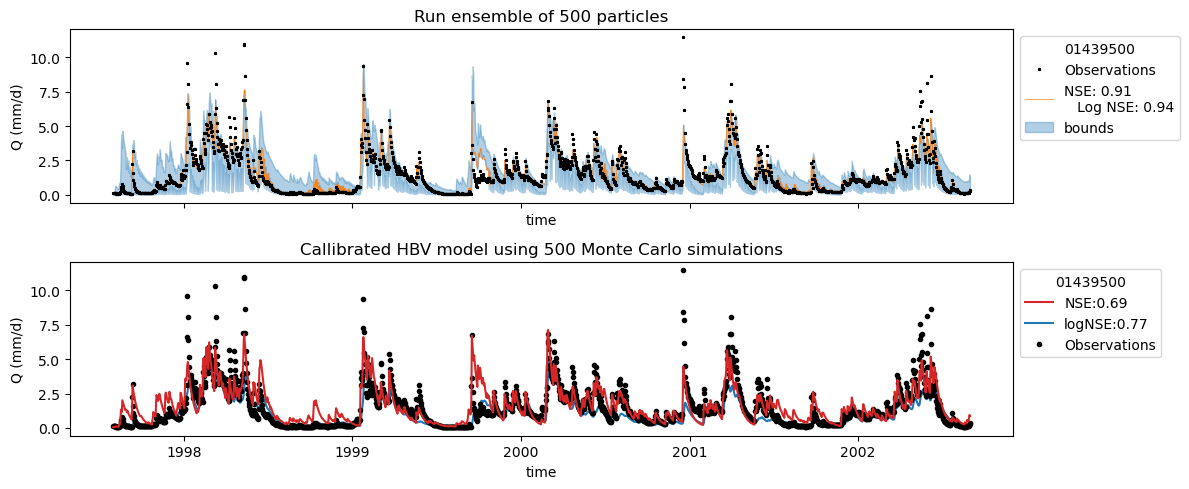

In [92]:
fig_tuple = plt.subplots(2,1, figsize=(12,5),sharex=True)
fig_tuple, ds_lst = generate_plots(df, basin_id, fig_tuple)
fig, ax = fig_tuple
# ax[0].set_title(f'Data assimilation with 500 particles for {np.array(ds_forcing["name"].values.ravel())[0].decode()}');
# fig.savefig(figure_path / f'data_assimilated_vs_callibrated value for {basin_id}.png',bbox_inches='tight',dpi=100)

In [93]:
fig_tuple, ds_lst = plot_residuals(ds_lst, (fig, ax[-1]))

Also get forcing

In [94]:
import warnings
warnings.simplefilter('ignore')
import ewatercycle.forcing
from ewatercycle.util import get_time

In [95]:
ds0, ds1 = ds_lst
start_time = f'{str(ds0.isel(time=0).time.values)}z'
end_time = f'{str(ds0.isel(time=-1).time.values)}z'
directory = Path.cwd() / "Forcing"

In [96]:
ds_in = xr.open_dataset('https://opendap.4tu.nl/thredds/dodsC/data2/djht/ca13056c-c347-4a27-b320-930c2a4dd207/2/camels.nc')

In [97]:
ds = ds_in.sel(basin_id=f'camels_{basin_id}'.encode(),data_source='daymet'.encode())

In [98]:
ds = ds.isel(basin_id=1)

In [99]:
start = pd.Timestamp(get_time(start_time)).tz_convert(None)
end = pd.Timestamp(get_time(end_time)).tz_convert(None)
ds = ds.isel(time=(ds["time"].to_numpy() >= start) & (ds["time"].to_numpy() <= end))

In [100]:
# will work in fucture but not just yet
# forcing = ewatercycle.forcing.sources.CaravanForcing.generate(start_time, end_time,directory,basin_id=f'camels_{basin_id}')

In [101]:
ds_forcing = ds
forcing_vars = ['streamflow', 'evspsblpot', 'pr', 'tas' ]
short_names = ['Q','E','P','T']
    
for index,param in enumerate(forcing_vars):
    ds_forcing[param].attrs['name'] = short_names[index]

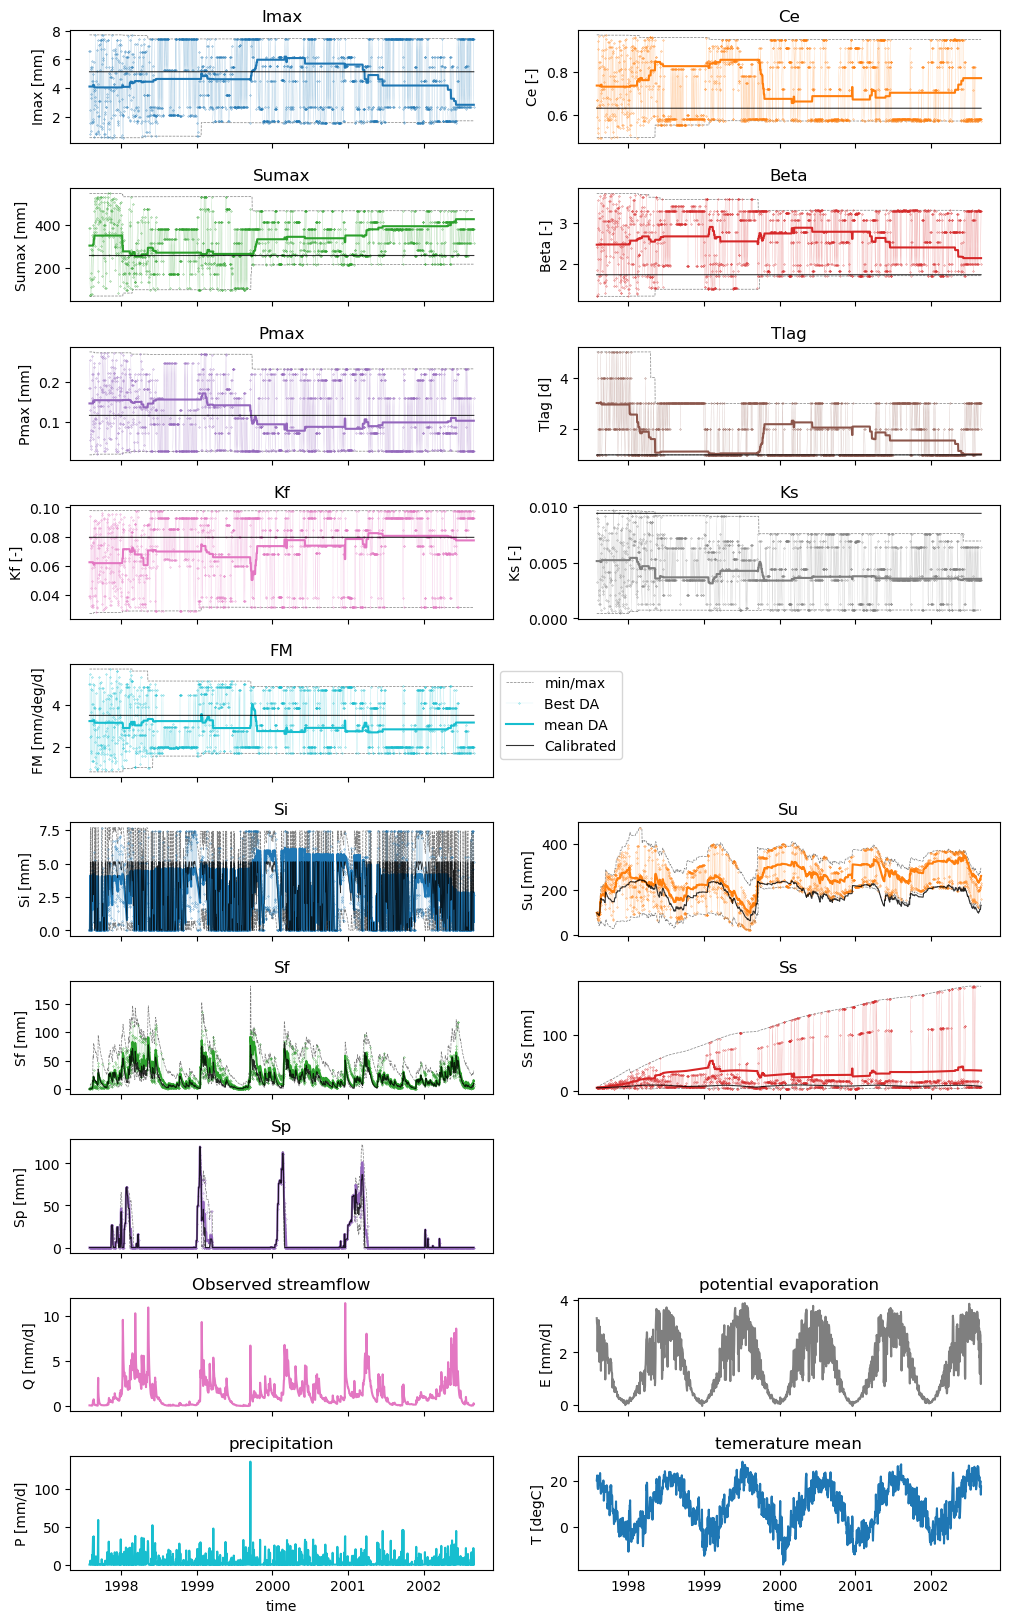

In [109]:
fig, ax = plt.subplots(10,2, figsize=(12,20),sharex=True)
ax = ax.flatten()
names = param_names + [None] + stor_names +[None]
plot_params(names, ds_lst, ax,
            forcing_names=forcing_vars,
            forcing_ds=ds_forcing,
            skip_states=False,
            lw_best=0.05,
            vertical=True
            )
# fig.tight_layout()
fig.subplots_adjust(hspace=0.4,wspace=0.2)
fig.savefig(figure_path/ f'comparison_parameters_states_{basin_id}.png', bbox_inches='tight',dpi=100)

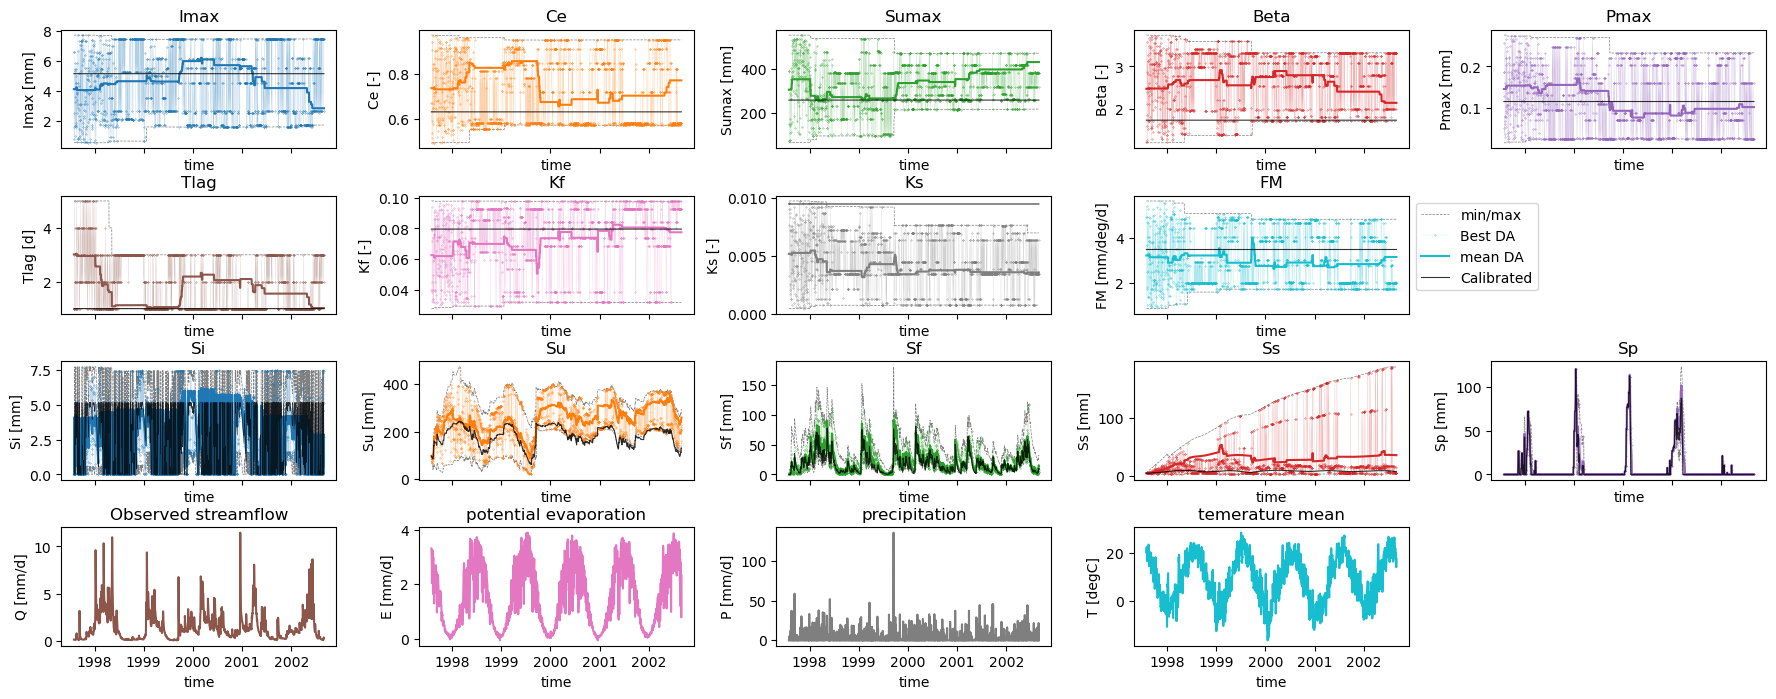

In [108]:
fig, ax = plt.subplots(4,5, figsize=(22,8),sharex=True)
ax = ax.flatten()
names = param_names + [None] + stor_names
plot_params(names, ds_lst, ax,
            forcing_names=forcing_vars + [None],
            forcing_ds=ds_forcing,
            skip_states=False,
            lw_best=0.05
            )
# fig.tight_layout()
fig.subplots_adjust(hspace=0.4,wspace=0.3)
# for j in [10,11,12,13,14]:
#     ax[j].set_xticks(ax[j].get_xticks(),ax[j].get_xticklabels(),rotation=90)
# fig.savefig(figure_path/ f'comparison_parameters_states_{basin_id}.png', bbox_inches='tight',dpi=100)

#### for presentation

In [ ]:
fig, ax  = plt.subplots(1,1, figsize=(15,5),sharex=True)
plot_only_calibration(ds_lst[1], ax)

# fig.savefig(figure_path / f'hydrograph_{basin_id}_.png',bbox_inches='tight',dpi=100)

In [ ]:
fig, ax  = plt.subplots(1,1, figsize=(15,5),sharex=True)
plot_hydrograph(ds_lst[0], ax, summary_stat='best')
ax.set_ylabel('Q (mm/d)')
ax.legend()
# fig.savefig(figure_path / f'hydrograph_assimilated_{basin_id}_.png',bbox_inches='tight',dpi=100)

# 13338500

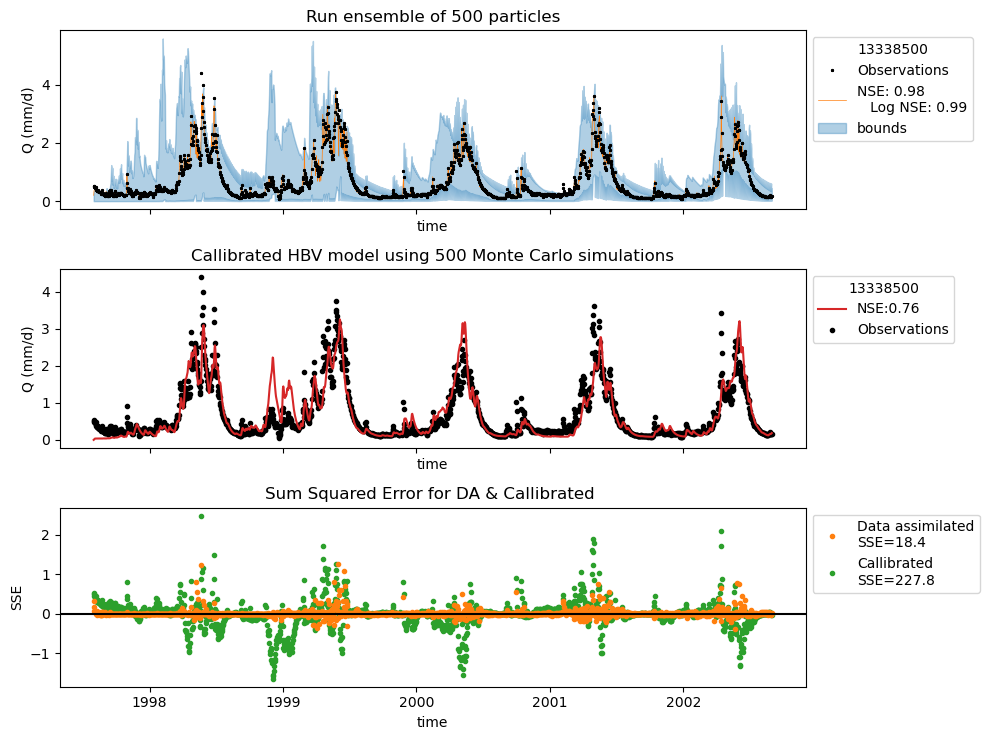

In [110]:
basin_id = '13338500'
fig_tuple = plt.subplots(3,1, figsize=(10,7.5),sharex=True)
fig_tuple, ds_lst = generate_plots(df, basin_id, fig_tuple)
fig, ax = fig_tuple
fig_tuple, ds_lst = plot_residuals(ds_lst, (fig, ax[-1]))
# fig.savefig(figure_path / f'residuals_and_hydrograph_{basin_id}.png',bbox_inches='tight',dpi=100)

In [111]:
ds0, ds1 = ds_lst
start_time = f'{str(ds0.isel(time=0).time.values)}z'
end_time = f'{str(ds0.isel(time=-1).time.values)}z'
directory = Path.cwd() / "Forcing"

In [112]:
ds_in = xr.open_dataset('https://opendap.4tu.nl/thredds/dodsC/data2/djht/ca13056c-c347-4a27-b320-930c2a4dd207/2/camels.nc')

In [113]:
ds = ds_in.sel(basin_id=f'camels_{basin_id}'.encode(),data_source='daymet'.encode())

In [114]:
start = pd.Timestamp(get_time(start_time)).tz_convert(None)
end = pd.Timestamp(get_time(end_time)).tz_convert(None)
ds = ds.isel(time=(ds["time"].to_numpy() >= start) & (ds["time"].to_numpy() <= end))

In [115]:
ds_forcing = ds
forcing_vars = ['streamflow', 'evspsblpot', 'pr', 'tas' ]
short_names = ['Q','E','P','T']
    
for index,param in enumerate(forcing_vars):
    ds_forcing[param].attrs['name'] = short_names[index]

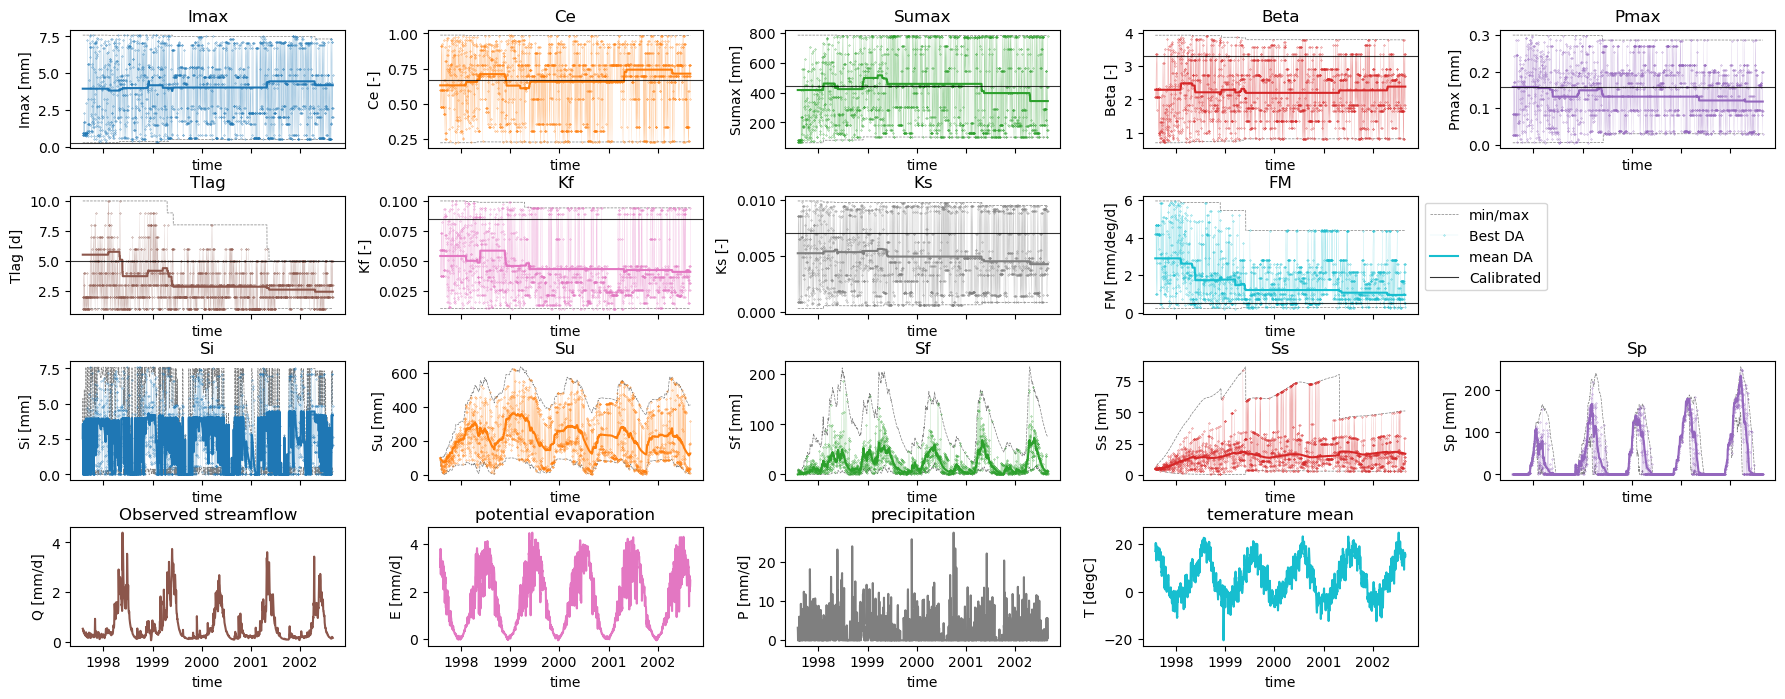

In [116]:
fig, ax = plt.subplots(4,5, figsize=(22,8),sharex=True)
ax = ax.flatten()
names = param_names + [None] + stor_names
plot_params(names, ds_lst, ax,
            forcing_names=forcing_vars + [None],
            forcing_ds=ds_forcing,
            skip_states=True,
            lw_best=0.05
            )
# fig.tight_layout()
fig.subplots_adjust(hspace=0.4,wspace=0.3)
fig.savefig(figure_path/ f'comparison_parameters_states_{basin_id}.png', bbox_inches='tight',dpi=100)

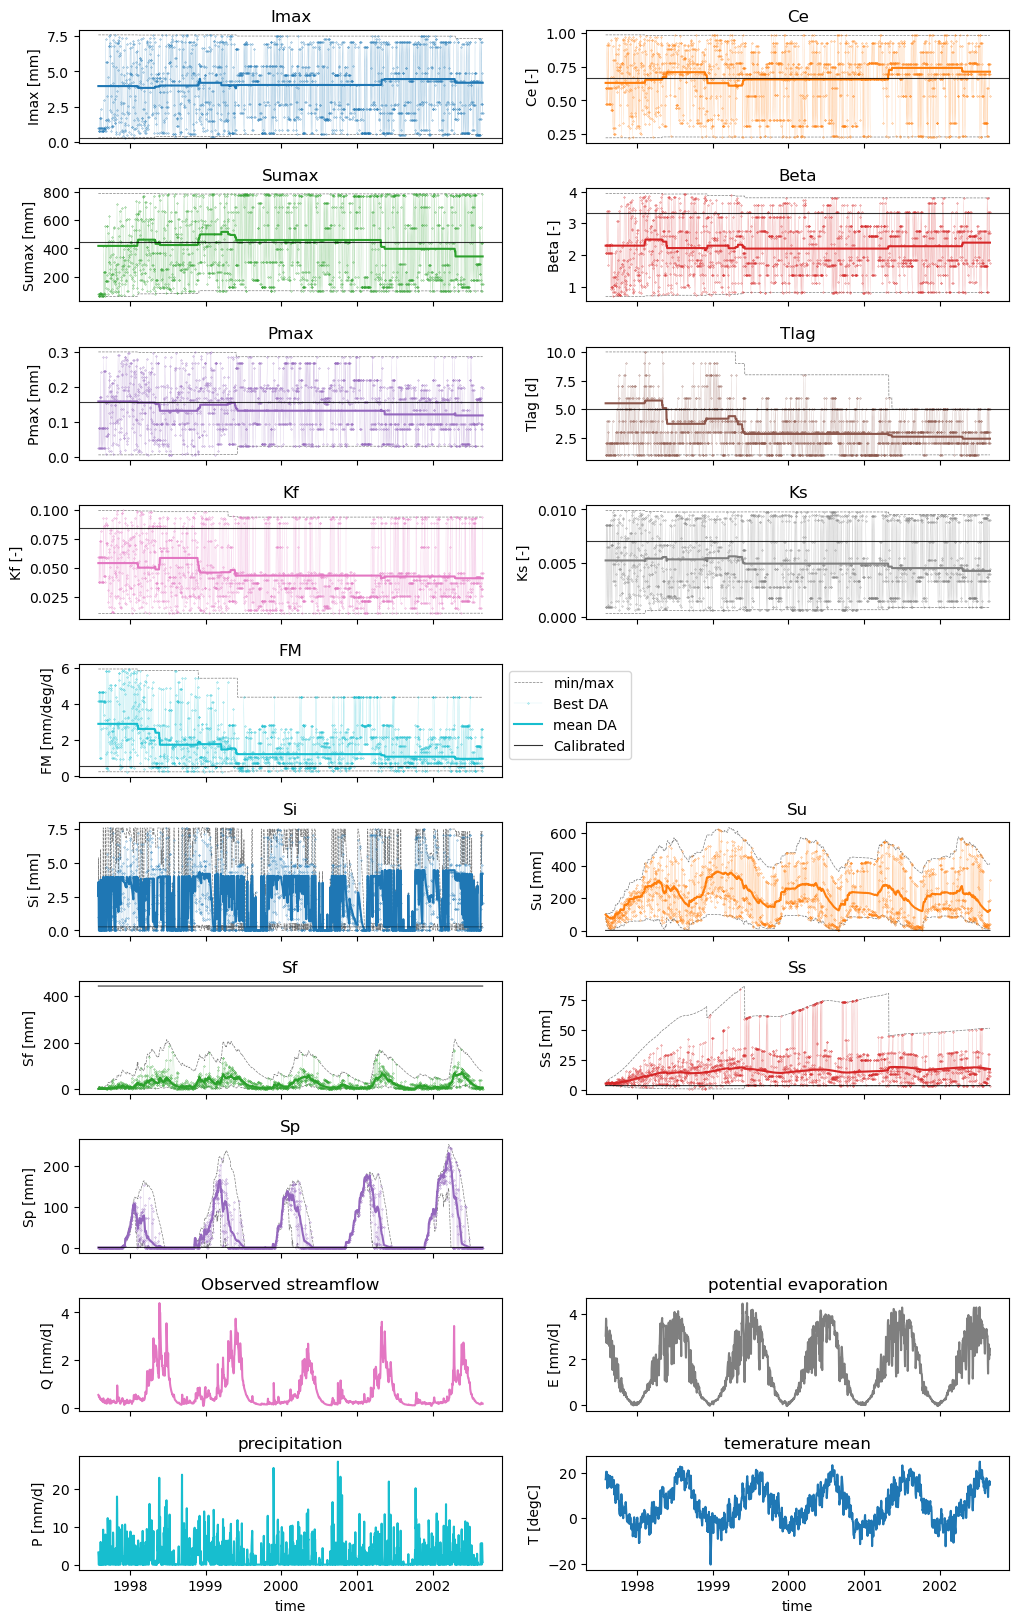

In [117]:
fig, ax = plt.subplots(10,2, figsize=(12,20),sharex=True)
ax = ax.flatten()
names = param_names + [None] + stor_names +[None]
plot_params(names, ds_lst, ax,
            forcing_names=forcing_vars,
            forcing_ds=ds_forcing,
            skip_states=False,
            lw_best=0.05,
            vertical=True
            )
# fig.tight_layout()
fig.subplots_adjust(hspace=0.4,wspace=0.2)
fig.savefig(figure_path/ f'comparison_parameters_states_{basin_id}_vertical.png', bbox_inches='tight',dpi=100)

# 04045500

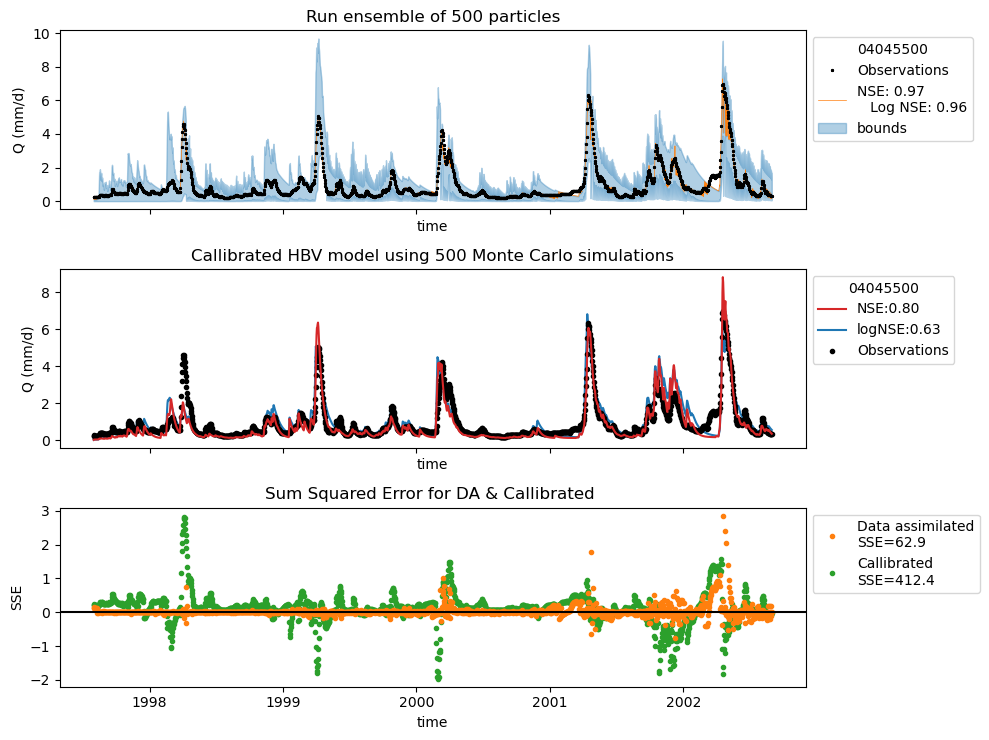

In [118]:
basin_id = '04045500'
fig_tuple = plt.subplots(3,1, figsize=(10,7.5),sharex=True)
fig_tuple, ds_lst = generate_plots(df, basin_id, fig_tuple)
fig, ax = fig_tuple
fig_tuple, ds_lst = plot_residuals(ds_lst, (fig, ax[-1]))
# fig.savefig(figure_path / f'residuals_and_hydrograph_{basin_id}.png',bbox_inches='tight',dpi=100)

In [119]:
ds0, ds1 = ds_lst
t_index = (ds0.time > np.datetime64('2000-09-01')) & (ds0.time < np.datetime64('2003-09-01')).values
ds_lst = [ds0.sel(time=t_index), ds1.sel(time=t_index)]

<Axes: title={'center': 'Run ensemble of 500 particles'}, xlabel='time', ylabel='Q [mm]'>

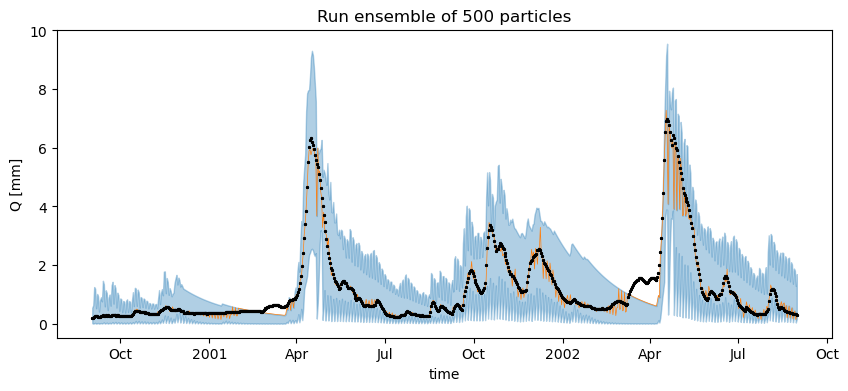

In [120]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
plot_hydrograph(ds_lst[0], ax, summary_stat='best')
# ds_lst[1]['Q'].plot(ax=ax,color='C3',label='calibrated')
# ax.legend()
# ax.set_title(f'{ds_lst[0].attrs["HRU_id"]}');
# fig.savefig(figure_path / f'zoomed_in_hydrograph_floodpeak_{basin_id}.png',bbox_inches='tight',dpi=100)

In [121]:
ds0, ds1 = ds_lst
start_time = f'{str(ds0.isel(time=0).time.values)}z'
end_time = f'{str(ds0.isel(time=-1).time.values)}z'
directory = Path.cwd() / "Forcing"

In [122]:
ds_in = xr.open_dataset('https://opendap.4tu.nl/thredds/dodsC/data2/djht/ca13056c-c347-4a27-b320-930c2a4dd207/2/camels.nc')

In [123]:
ds = ds_in.sel(basin_id=f'camels_{basin_id}'.encode(),data_source='daymet'.encode()).isel(basin_id=1)

In [124]:
start = pd.Timestamp(get_time(start_time)).tz_convert(None)
end = pd.Timestamp(get_time(end_time)).tz_convert(None)
ds = ds.isel(time=(ds["time"].to_numpy() >= start) & (ds["time"].to_numpy() <= end))

In [125]:
ds_forcing = ds
forcing_vars = ['streamflow', 'evspsblpot', 'pr', 'tas' ]
short_names = ['Q','E','P','T']
    
for index,param in enumerate(forcing_vars):
    ds_forcing[param].attrs['name'] = short_names[index]

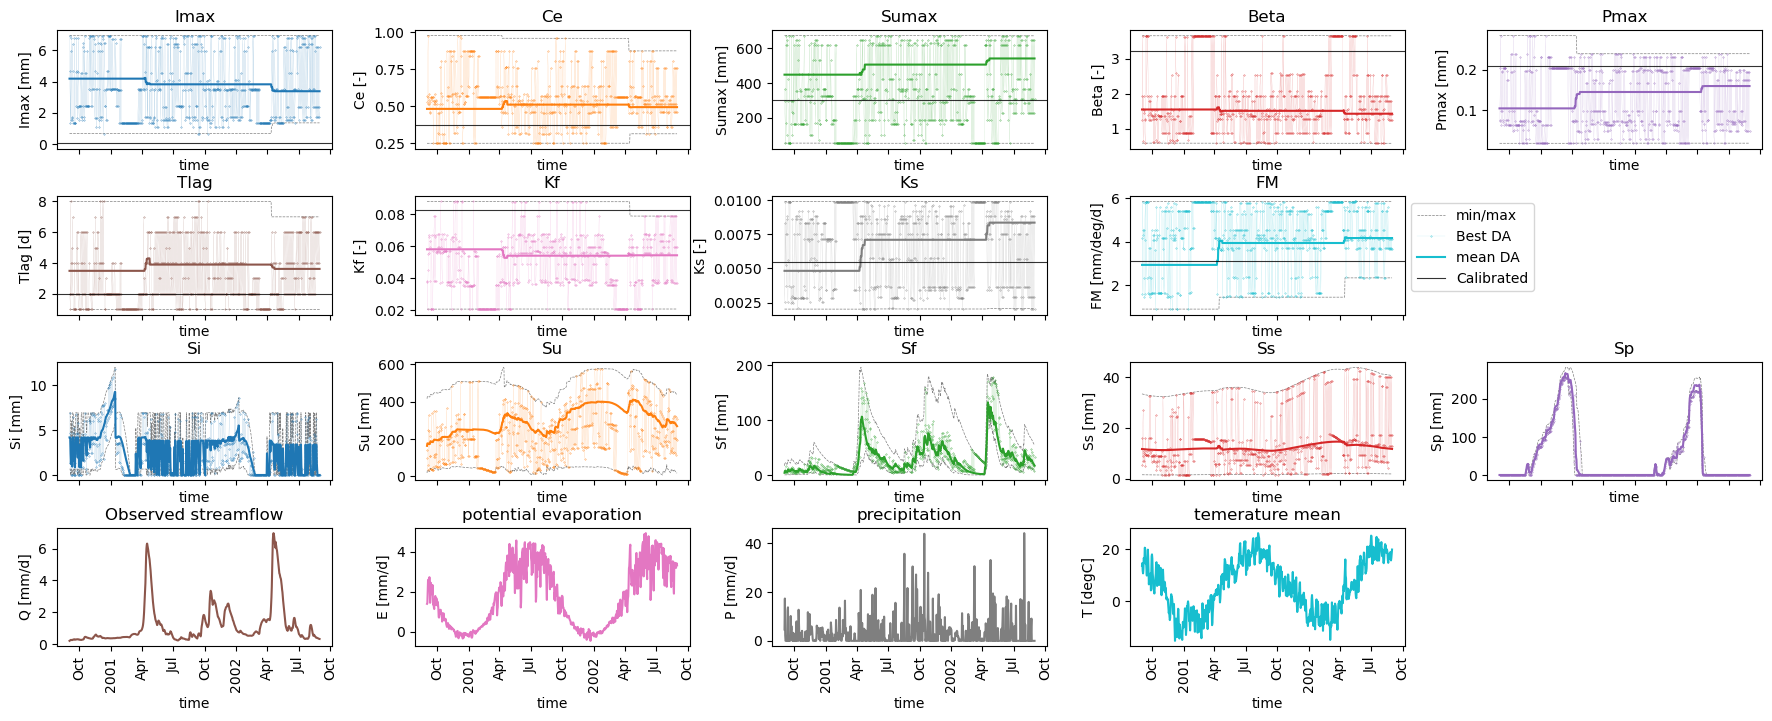

In [126]:
fig, ax = plt.subplots(4,5, figsize=(22,8),sharex=True)
ax = ax.flatten()
names = param_names + [None] + stor_names
plot_params(names, ds_lst, ax,
            forcing_names=forcing_vars + [None],
            forcing_ds=ds_forcing,
            skip_states=True,
            lw_best=0.05
            )
# fig.tight_layout()
fig.subplots_adjust(hspace=0.4,wspace=0.3)
for j in [15,16,17,18]:
    ax[j].set_xticks(ax[j].get_xticks(),ax[j].get_xticklabels(),rotation=90)
fig.savefig(figure_path/ f'comparison_parameters_states_{basin_id}.png', bbox_inches='tight',dpi=100)

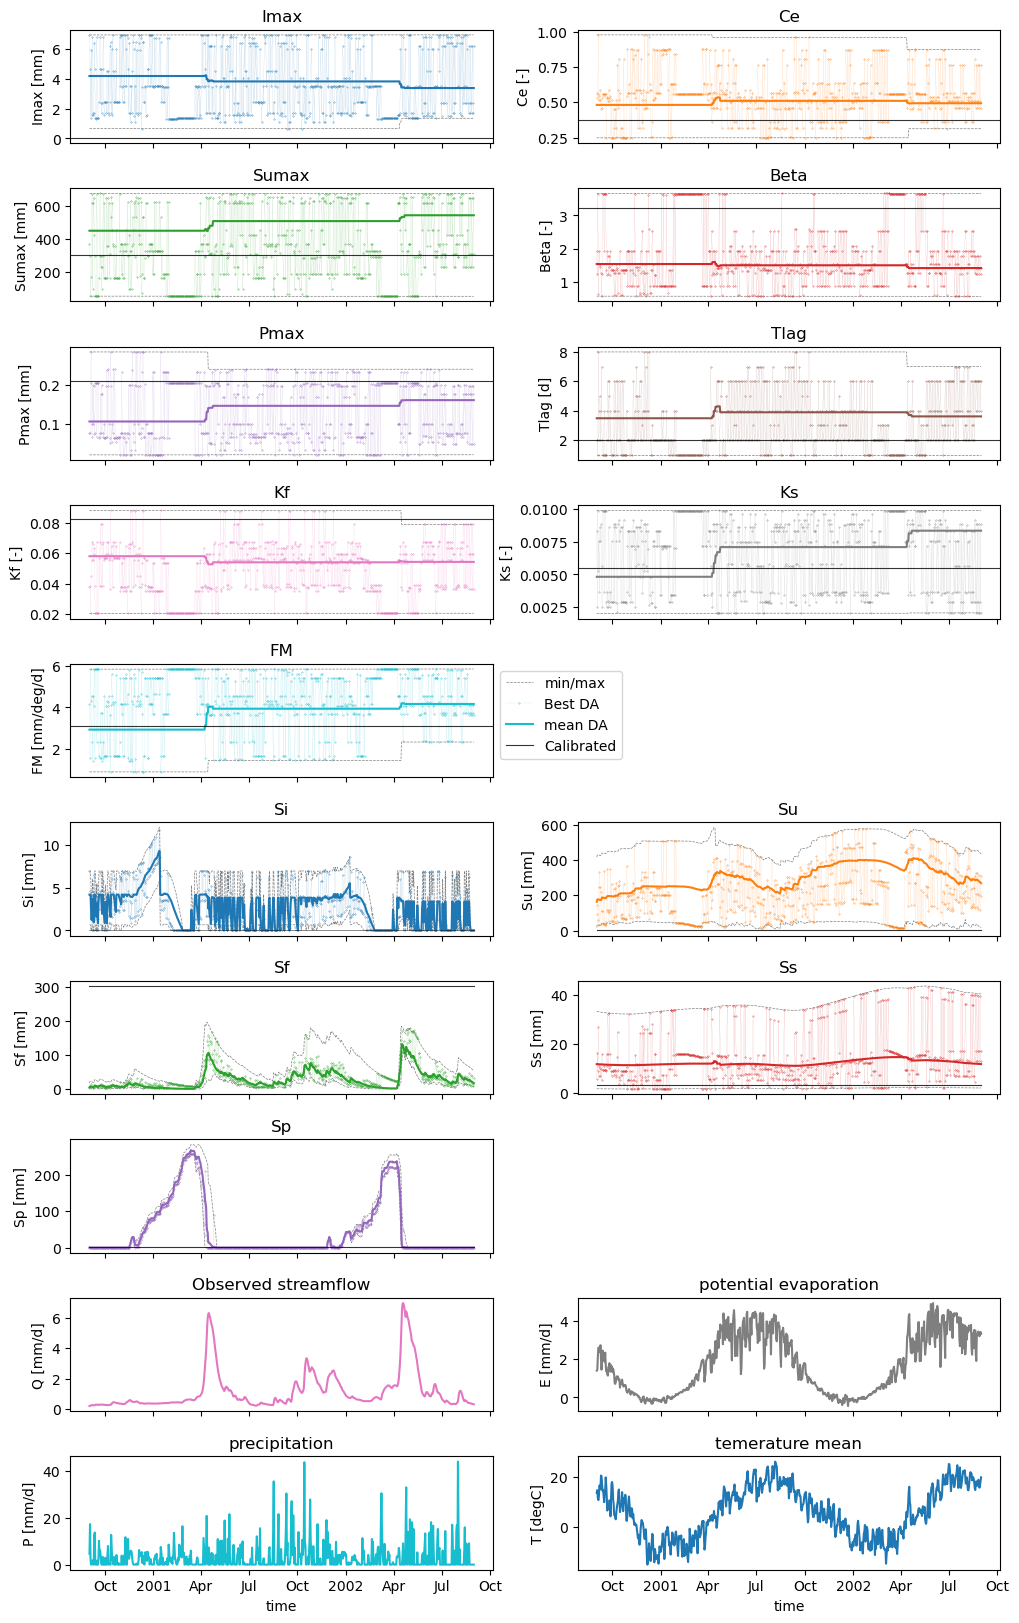

In [127]:
fig, ax = plt.subplots(10,2, figsize=(12,20),sharex=True)
ax = ax.flatten()
names = param_names + [None] + stor_names +[None]
plot_params(names, ds_lst, ax,
            forcing_names=forcing_vars,
            forcing_ds=ds_forcing,
            skip_states=False,
            lw_best=0.05,
            vertical=True
            )
# fig.tight_layout()
fig.subplots_adjust(hspace=0.4,wspace=0.2)
fig.savefig(figure_path/ f'comparison_parameters_states_{basin_id}_vertical.png', bbox_inches='tight',dpi=100)

In [ ]:
# fig, ax = plt.subplots(3,5, figsize=(22,6),sharex=True)
# ax = ax.flatten()
# names = param_names + [None] + stor_names
# plot_params(names,ds_lst,ax, skip_states=True,lw_best=0.2)
# # fig.tight_layout()
# fig.subplots_adjust(hspace=0.4,wspace=0.3)
# for j in [10,11,12,13,14]:
#     ax[j].set_xticks(ax[j].get_xticks(),ax[j].get_xticklabels(),rotation=90)
# # fig.savefig(figure_path/ f'comparison_parameters_states_{basin_id}_peaks.png', bbox_inches='tight',dpi=100)

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(8,4.5),sharex=True)
ax[0] = plot_hydrograph(ds_lst[0], ax[0], 'best')
ax[0].legend(title=f"HRU: {ds_lst[0].attrs['HRU_id']}",bbox_to_anchor=(1.,1.1))
for j, val in enumerate(['n_resample','Neff']):
    ax[j+1].plot(ds_lst[0]['time'].values, ds_lst[0][val].values,color=f"C{j+3}",label=val)
    ax[j+1].legend()
    ax[j+1].set_ylabel('Number of particles')
ax[2].axhline(ds_lst[0].attrs['n_particles']*0.975, color='k');